In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<ipython-input-2-d3b75f2f6314>:50: RuntimeWarning: invalid value encountered in log1p
  data = np.log1p(np.clip(data, a_min=1e-6, a_max=None))  # Avoid log of zero
<ipython-input-2-d3b75f2f6314>:52: RuntimeWarning: invalid value encountered in cast
  img = Image.fromarray(np.uint8(data * 255)).convert("RGB").resize(size)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/10
110/110 [==============================] - 118s 793ms/step - loss: 1.0024 - accuracy: 0.6400 - val_loss: 0.6157 - val_accuracy: 0.7947
Epoch 2/10
110/110 [==============================] - 83s 756ms/step - loss: 0.5378 - accuracy: 0.8071 - val_loss: 0.4767 - val_accuracy: 0.8400
Epoch 3/10
110/110 [==============================] - 83s 755ms/step - loss: 0.4463 - accuracy: 0.8340 - val_loss: 0.4431 - val_accuracy: 0.8480
Epoch 4/10
110/110 [==============================] - 83s 756ms/step - loss: 0.4026 - accuracy: 0.8466 - val_loss: 0.4183 - val_accuracy: 0.8293
Epoch 5/10
110/110 [==============================] - 83s 755ms/step - loss: 0.3833 - accuracy: 0.8531 - val_loss: 0.4522 - val_accuracy: 0.8400
Epoch 6/10
110/110 [==============================] - 83s 755ms/step - loss: 0.4084 - accuracy: 0.8414 - val_loss: 0.4216 - val_accuracy: 0.8440
Epoch 7/10
110/110 [==============================] - 83s 756ms/step - loss: 0.4049 - accuracy: 0.8446 - val_loss: 0.4240 - val_a

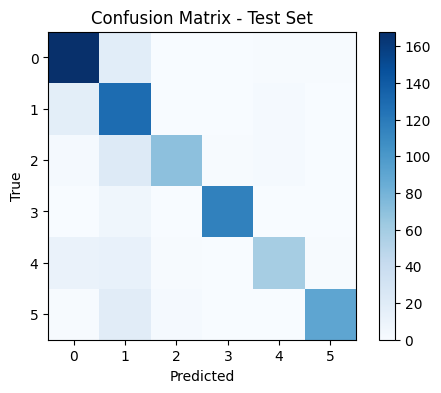

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import pyarrow.parquet as pq
import io
from PIL import Image

# Define dataset directories
data_csv = "/kaggle/input/hms-harmful-brain-activity-classification/train.csv"
parquet_dir = "/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms"

# Load metadata
df = pd.read_csv(data_csv)

# Filter rows that have corresponding parquet files
existing_files = set(os.listdir(parquet_dir))
df = df[df["spectrogram_id"].apply(lambda x: f"{x}.parquet" in existing_files)]

# Limit to first 5000 samples
df = df.head(5000)

if df.empty:
    raise ValueError("No matching parquet files found. Check your directory and filenames.")

# Encode labels
y = df["expert_consensus"].dropna()
df = df.loc[y.index]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Metadata features
X_meta = df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].values
scaler = StandardScaler()
X_meta = scaler.fit_transform(X_meta)

# Helper to convert spectrogram parquet to image array
def load_spectrogram_as_image(spectrogram_id, size=(224, 224)):
    file_path = os.path.join(parquet_dir, f"{spectrogram_id}.parquet")
    table = pq.read_table(file_path)
    data = table.to_pandas().values.T  # Transpose to get (freq, time)
    data = np.log1p(np.clip(data, a_min=1e-6, a_max=None))  # Avoid log of zero
    data = (data - np.min(data)) / (np.max(data) - np.min(data) + 1e-8)
    img = Image.fromarray(np.uint8(data * 255)).convert("RGB").resize(size)
    return np.array(img)

# Load spectrogram images
X_images = np.stack([load_spectrogram_as_image(sid) for sid in df["spectrogram_id"]])

# Normalize images to 0-1 range for Hugging Face models
X_images = X_images / 255.0

# Split dataset
X_img_train, X_img_temp, X_meta_train, X_meta_temp, y_train, y_temp = train_test_split(
    X_images, X_meta, y_categorical, test_size=0.3, random_state=42, stratify=y_categorical)
X_img_val, X_img_test, X_meta_val, X_meta_test, y_val, y_test = train_test_split(
    X_img_temp, X_meta_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Vision Transformer from Hugging Face
from transformers import TFViTModel
vit_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

image_input = keras.Input(shape=(224, 224, 3), name="image_input")

# Custom wrapper to apply ViT
class ViTWrapper(layers.Layer):
    def __init__(self, vit_model):
        super(ViTWrapper, self).__init__()
        self.vit_model = vit_model

    def call(self, inputs):
        # Convert from (B, 224, 224, 3) to (B, 3, 224, 224)
        pixel_values = tf.transpose(inputs, perm=[0, 3, 1, 2])
        outputs = self.vit_model(pixel_values=pixel_values, training=False)
        return outputs.last_hidden_state[:, 0]  # CLS token

x = ViTWrapper(vit_model)(image_input)
x = layers.Dense(128, activation='relu')(x)
image_features = layers.Dropout(0.3)(x)

# Metadata model
meta_input = keras.Input(shape=(X_meta.shape[1],), name="meta_input")
y_meta = layers.Dense(32, activation='relu')(meta_input)
meta_features = layers.Dense(16, activation='relu')(y_meta)

# Merge models
merged = layers.concatenate([image_features, meta_features])
z = layers.Dense(64, activation='relu')(merged)
out = layers.Dense(y_categorical.shape[1], activation='softmax')(z)

model = keras.Model(inputs=[image_input, meta_input], outputs=out)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(
    x=[X_img_train, X_meta_train],
    y=y_train,
    epochs=10,
    batch_size=32,
    validation_data=([X_img_val, X_meta_val], y_val)
)

# Evaluate model
y_pred = model.predict([X_img_test, X_meta_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Test Accuracy:", accuracy_score(y_true_classes, y_pred_classes))
print("Test Report:\n", classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
plt.figure(figsize=(6, 4))
plt.imshow(confusion_matrix(y_true_classes, y_pred_classes), cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()